# Gold Code Generator

This notebook generates the Gold Codes for a particular satellite. This process was outlined in a [2014 post](https://natronics.github.io/blag/2014/gps-prn/) by PSAS's own Nathan Bergey.

## About Gold Codes

Gold codes are also known as coarse acquisition (C/A) codes or pseudo-random noise (PRN) codes. Each term has its own connotations, but for the most part, they are synonymous. 

Each one serves as the unique identifier for one of the 32 GPS satellites in orbit. They are generated by two 10 bit shift registers that have feedback taps at certain specified points. The pair of output taps are unique to each satellite. Check out Nathan's post for more details (it's linked above). The  ones and zeros generated are called "chips" to differentiate them from bits, because they do not carry any information on their own. We will see how to extract data using the Gold Codes later on.

## Setup

We store the shift registers as deques rather than standard lists so that we can use the handy deque.rotate() function.

In [12]:
import string
import numpy as np
#Store the shift registers as a deque, so that deque.rotate{} can be used.
from collections import deque  
import matplotlib.pyplot as plt

## Input

Below, set the tap location for the desired satellite. There are lists of the tap locations in most GPS resources, they are also listed in Nathan's blog post.

In [2]:
# Set tap for a particular satellite
tap = (1, 5)

## Class

Below is a GoldCode class. Function descriptions are outlined below.

### _shift()

Shifts g1 and g2 by a single increment. Only intended for use by from within the class.

### reset()

Returns g1 and g2 to their starting position (all 1's)

### getCode(num)

Returns Gold Code chips in a list of size *num*. Picks up from whatever the last bits returned were.

In [3]:
class GoldCode:
      
    
    #Feedback taps as defined in GPS spec
    g1tap = [2,9]
    g2tap = [1,2,5,7,8,9]

    
    def __init__(self, taps):
        
        self.reset()
        self.tap = taps
        
        # Current index of the last returned code
        self.index = 0
        
    # Shift SRs
    def _shift(self):
        #Shift g1
        self.g1[9] = sum([self.g1[i] for i in self.g1tap]) % 2 
        self.g1.rotate()

        #Shift g2
        self.g2[9] = sum([self.g2[i] for i in self.g2tap]) % 2 
        self.g2.rotate()
        
        self.index = (self.index % 1023) + 1
        
    def reset(self):
        # Inititialize SRs as all 1's
        self.g1 = deque(1 for i in range(10))
        self.g2 = deque(1 for i in range(10))
        self.index = 0

    def getCode(self, num):
        #Returns a list of bits that form the Gold Code PRN of the designated satellite
        g = []

        for i in range(num):
            val = (self.g1[9] + self.g2[tap[0]] + self.g2[tap[1]]) % 2
            g.append(val)
            self._shift()

        return g

## Does the Gold code repeat after 1023 chips? 

As you can see below, it does!

In [4]:
satCode = GoldCode(tap)
first = satCode.getCode(1023)
print(str(first).replace(', ', ''))
print(satCode.index)

print()
print()

second = satCode.getCode(1023)
print(str(second).replace(', ', ''))
print(satCode.index)



[110010000011100101001001111001010001001111101010110100010001010101011001000111101001111110110111001101111100101010100001000000001110101001000100110111100000111101011100110011110110000000101111001111101010011000101101110001101111010100010101100000100000000100000011000111011000000111000110111111111010011101001011011000010101011000100111001011011101100011101110111100001101100001100100100100000110110100101101111000101110000001010010011111100000101010111001111101011111001100110001110001101101010101101100011011101110000000000010110011011001110110100000101010111010111010010100011100111000100101000101001011010000101011011010110110001110011110110010000111111001011010001000011111010101110011001001001001011111111110000111110111100011011100101100001110010101000010100101011111100011110110100111011001111110111110100011000111110000000100101000101101000100010011011000000111011010001101000100100011100010110011001001111001101111110011001010011010011010111100110110101001110111100011010100010000100010010

## Try it Yourself

Choose another satellite, and make the Gold code for it

In [5]:
# Do some cool stuff here

# Sampling

We can not use our shiny new Gold Code for coarse acquisition just yet. While we know the pattern, we need to stretch it out so that it looks the same as how our ADC sees it. The chipping rate of the GPS satellites is 1023 MCps. Note that this means the code repeats every 1ms.  Our ADC is set to sample at 4.092 MHz (1023 MHz * 4). Thus, the ADC should be sampling each chip 4 times. 

What we need to do is repeat each chip 4 times. Luckily numpy makes this easy for us.

In [8]:
#Re use 'first' from the previous block
sampledCode = np.repeat(first, 4)
print(sampledCode[0:100])

[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0
 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


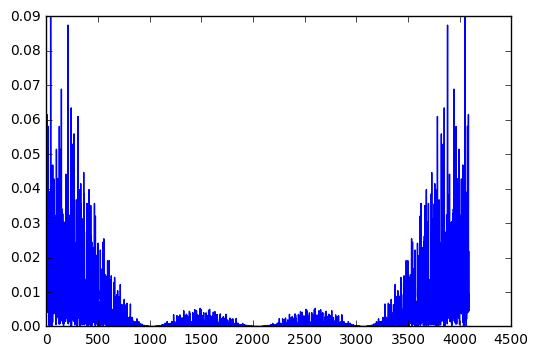

In [27]:

for n,i in enumerate(first):                                                                                                                                           
    if i==0:                                                                                                                                                       
         first[n]=-1 

firstsamp = np.repeat(first, 4)
    
CAP = np.conj(np.fft.fft(firstsamp))
plt.plot(((np.abs(CAP))**2)/(10**6))
plt.show()